<img src = "https://drive.google.com/uc?export=view&id=14gEPsrwVW1YirTsGjU_wMsu2UwmEpaFE"> <br>
### Women in Data Science Brown Bag Series: Algorithm Selection, Model Evaluation, and Hyperparameter Tuning
Sian Lewis (lewis_sian@bah.com)<br>
Marissa Wiener (wiener_marissa@bah.com)<br>
<br>
February 7, 2019

In this brown bag, we explore model selection, hyperparameter tuning, and model evaluation for classic regression and classification models. Learn to choose the best model/algorithm for prediction through different techniques.

This notebook should be compatible with both google colab and jupyter notebook, just pay attention to slight differences in setup and with using the SHAP package.

### **Part 1:** Algorithm Selection <br>
When choosing an algorithm, consider the objective and use of the model. Some main considerations are listed below: <br><br>
**Data**<br>
How many features and instances are in your dataset? <br>
Is your data sparse? <br>
Are there a lot of null values? Are nulls biased? <br>
Are the attributes in your data correlated?<br>
Are you predicting a continuous or categorical variable?<br><br>
**Interpretability** <br>
Is your purpose accuracy only? Does interpretability not matter at all? <br>
Are there regulations or other business/legal considerations which require an explanation of the model <br>
Could the interpretability of your model be used for other business applications?<br><br>
**Speed**<br>
Is speed of fit important? <br>
Are there any limitations to computing power? <br>

<img src = "https://drive.google.com/uc?export=view&id=1Pv907fQVf7dfGm1udaXN1IcrcIi5jP7E"> <br>



Classification & Regression: <br>
- *Regression*: given a set of data, find the best relationship that represents the set of data. Predicts continuous variables.

- *Classification*: given a known relationship, identify the class that the data belongs to.

Regression finds a pattern and classification finds the pattern that it belongs to.



Let's consider classification algorithms:
- *Logistic Regression:* not great to use with a ton of features or correlated features, highly interpretable output. Logistic regression and linear are the same, except that logistic regresssion applies a threshold to determine classes.
- *Tree Based Methods:* many features which could be correlated, seeking accuracy but willing to sacrifice a bit of interpretation
  - *Decision Tree:* A dichotomized tree where each node represents a feature (attribute), each link (branch) represents a decision (rule) and each leaf represents an outcome (categorical or continuous value).
  - *Random Forest:* uses bagging to train data (average of model output trained on randomly selected data with replacement), harder to overfit and easier to tune, good with very large data
  - *Gradient Boosted Trees:* train base model, then fit subsequent additive models to residuals, good for imbalanced classes, seeking accuracy, be careful about overfitting; flexible to all differentiable loss functions
- *Deep learning/Neural Networks:* many features, seeking accuracy and no need for interpretation

In this tutorial, we chose classification models because that are easy to interpret and demonstrate.

### **Part 2:** Model Evaluation

In [0]:
import zipfile as z
import pandas as pd
import seaborn as sns
import re
import math
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
## helpful for getting shap to work in jupyter notebooks (windows):
## if you don't have the following packages installed, you can do so here
### you may have to troubleshoot if you get an error related to C++
### helpful link: https://stackoverflow.com/questions/48541801/microsoft-visual-c-14-0-is-required-get-it-with-microsoft-visual-c-build-t

## colab notebook quirks (only need to run once if errors crop up)
#!pip uninstall xgboost # older version
#!pip install xgboost
#!pip install -U imbalanced-learn # not totally positive you need to install

## always run
!pip install shap
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

**FOR GOOGLE COLAB SETUP:**

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/'

 data.zip  'wids-model-selection-eval-brownbag-101 (1).ipynb'
 pickle/    wids-model-selection-eval-brownbag-101.ipynb
 source/


In [5]:
# load in data file without unzipping
zip_link = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/data.zip'
archive = z.ZipFile(zip_link,'r')
food_inspections = archive.open('data/food-inspections.csv')
df = pd.read_csv(food_inspections)
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2240307,2 POTZ & A PAN EATERY,2 POTZ & A PAN EATERY,2626283.0,Restaurant,Risk 1 (High),6052 S EBERHART AVE,CHICAGO,IL,60637.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.784183,-87.613385,"{'longitude': '-87.61338492635632', 'needs_rec..."
1,2240303,"CREMERIA SANTA MARIA, INC",CREMERIA SANTA MARIA,1868311.0,Grocery Store,Risk 1 (High),3424 W 26TH ST,CHICAGO,IL,60623.0,2018-11-16T00:00:00,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.844544,-87.711073,"{'longitude': '-87.71107279676545', 'needs_rec..."
2,2240297,ORALE,ORALE,2631871.0,Restaurant,Risk 1 (High),1623 W 43rd ST,CHICAGO,IL,60609.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.815747,-87.666218,"{'longitude': '-87.66621797293804', 'needs_rec..."
3,2240300,AMAZING GRACE DAYCARE CENTER,AMAZING GRACE DAYCARE CENTER,2215901.0,Daycare Above and Under 2 Years,Risk 1 (High),11123-11125 S HALSTED ST,CHICAGO,IL,60628.0,2018-11-16T00:00:00,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.691646,-87.642214,"{'longitude': '-87.6422140544927', 'needs_reco..."
4,2240286,JOYS,JOYS,1677471.0,Restaurant,Risk 1 (High),3257-3259 N BROADWAY,CHICAGO,IL,60657.0,2018-11-16T00:00:00,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.941713,-87.644306,"{'longitude': '-87.64430633617879', 'needs_rec..."


**FOR JUPYTER NOTEBOOK SETUP:**

In [0]:
# # load in data file without unzipping
# archive = z.ZipFile('data.zip','r')
# food_inspections = archive.open('data/food-inspections.csv')
# df = pd.read_csv(food_inspections)
# df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2240307,2 POTZ & A PAN EATERY,2 POTZ & A PAN EATERY,2626283.0,Restaurant,Risk 1 (High),6052 S EBERHART AVE,CHICAGO,IL,60637.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.784183,-87.613385,"{'longitude': '-87.61338492635632', 'needs_rec..."
1,2240303,"CREMERIA SANTA MARIA, INC",CREMERIA SANTA MARIA,1868311.0,Grocery Store,Risk 1 (High),3424 W 26TH ST,CHICAGO,IL,60623.0,2018-11-16T00:00:00,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.844544,-87.711073,"{'longitude': '-87.71107279676545', 'needs_rec..."
2,2240297,ORALE,ORALE,2631871.0,Restaurant,Risk 1 (High),1623 W 43rd ST,CHICAGO,IL,60609.0,2018-11-16T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.815747,-87.666218,"{'longitude': '-87.66621797293804', 'needs_rec..."
3,2240300,AMAZING GRACE DAYCARE CENTER,AMAZING GRACE DAYCARE CENTER,2215901.0,Daycare Above and Under 2 Years,Risk 1 (High),11123-11125 S HALSTED ST,CHICAGO,IL,60628.0,2018-11-16T00:00:00,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.691646,-87.642214,"{'longitude': '-87.6422140544927', 'needs_reco..."
4,2240286,JOYS,JOYS,1677471.0,Restaurant,Risk 1 (High),3257-3259 N BROADWAY,CHICAGO,IL,60657.0,2018-11-16T00:00:00,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.941713,-87.644306,"{'longitude': '-87.64430633617879', 'needs_rec..."


**Get to know the Data**
- Food inspection data from Illinois, indicates pass/fail criteria
- Available on Kaggle: https://www.kaggle.com/chicago/chi-restaurant-inspections

In [6]:
# format column names to remove whitespace and special characters
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('#','nb')
df.columns 

Index(['inspection_id', 'dba_name', 'aka_name', 'license_nb', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [7]:
#look at dimensions of data and data types
print(df.shape)
print(df.dtypes[df.dtypes=='object'])
print(df.dtypes[df.dtypes!='object'])

# can you print value counts for the categorical variables?
# should we change data type for any of the numeric columns?

(178089, 17)
dba_name           object
aka_name           object
facility_type      object
risk               object
address            object
city               object
state              object
inspection_date    object
inspection_type    object
results            object
violations         object
location           object
dtype: object
inspection_id      int64
license_nb       float64
zip              float64
latitude         float64
longitude        float64
dtype: object


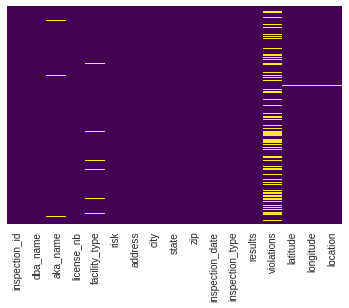

In [8]:
# visualize nulls values in each column
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [9]:
# we want to base our dependent variable on the 'results' column
# look more closely at values
print(df.results.describe())
df.results.value_counts()

count     178089
unique         7
top         Pass
freq      101807
Name: results, dtype: object


Pass                    101807
Fail                     34505
Pass w/ Conditions       19317
Out of Business          15606
No Entry                  5382
Not Ready                 1408
Business Not Located        64
Name: results, dtype: int64

In [10]:
# make indicator variables to represent 'pass' and 'fail'
# in this example we will be modeling 'pass', but feel free to experiment with
# predicting 'fail' on your own!
condition_list = [df['results']=='Pass', df['results'] == 'Pass w/ Conditions']
choice_list = [1,1]
df['pass'] = np.select(condition_list, choice_list, default = 0)
df['fail'] = np.where(df['results']=='Fail', 1, 0)
df.describe()

,inspection_id,license_nb,zip,latitude,longitude,pass,fail
count,1.780890e+05,1.780730e+05,178013.000000,177425.000000,177425.000000,178089.000000,178089.000000
mean,1.361486e+06,1.563803e+06,60628.998466,41.880761,-87.676449,0.680132,0.193751
std,6.042818e+05,8.890138e+05,22.675410,0.080798,0.058927,0.466427,0.395238
min,4.424700e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000,0.000000
25%,1.106299e+06,1.169489e+06,60614.000000,41.832016,-87.707453,0.000000,0.000000
50%,1.441571e+06,1.954184e+06,60625.000000,41.891671,-87.666290,1.000000,0.000000
75%,1.950624e+06,2.215518e+06,60643.000000,41.939692,-87.634789,1.000000,0.000000
max,2.240307e+06,9.999999e+06,60827.000000,42.021064,-87.525094,1.000000,1.000000


In [11]:
# handle date column and create new associated date columns
df['inspection_date'] = pd.to_datetime(df.inspection_date)
# max date in df is 11/2018, so counting months from 1/1/2019
df['inspection_recency_in_months'] = (pd.to_datetime('1/1/2019') - \
                                      df.inspection_date) / np.timedelta64(1,'M')
df['inspection_month'] = df.inspection_date.dt.month # to be handled as categorical
df['inspection_year'] = df.inspection_date.dt.year # to be handled as categorical

# handle categorical columns with many levels
# quick helper function to bin categorical vars
def grouping_helper(x, keep_list):
    if x in keep_list:
        x = re.sub('[^A-Za-z0-9]+','',x).lower()
    else:
        x = 'other'
    return x
# choose the min number of rows for levels of categorical variables 
# based on threshold of value counts
keep_levels_aka_name = df['aka_name'].value_counts()[df['aka_name'].value_counts().values > 100].index
keep_levels_facility_type = df['facility_type'].value_counts()[df['facility_type'].value_counts().values > 50].index
keep_levels_inspection_type = df['inspection_type'].value_counts()[df['inspection_type'].value_counts().values > 50].index

# apply function to each column
df['aka_name_grp'] = [grouping_helper(r, keep_levels_aka_name) for r in df['aka_name']]
# further group establishments which clearly are the same 
df['aka_name_grp'] = np.where(df['aka_name_grp']=='haroldschickenshack','haroldschicken',df['aka_name_grp'])
df['aka_name_grp'] = np.where(df['aka_name_grp']=='subwaysandwiches','subway',df['aka_name_grp'])
df['facility_type_grp'] = [grouping_helper(r, keep_levels_facility_type) for r in df['facility_type']]
# further group levels beginning with 'daycare'
df['facility_type_grp'] = np.where([re.match('^daycare', d) for d in df['facility_type_grp']],\
                                   'daycare', df['facility_type_grp'])
df['inspection_type_grp'] = [grouping_helper(r, keep_levels_inspection_type) for r in df['inspection_type']]

# print new value counts
print([df[x].value_counts() for x in ['aka_name_grp','facility_type_grp','inspection_type_grp']])

df.head(10) # check out data to make sure grouping looks ok

[other                        164056
subway                         3390
mcdonalds                      1427
dunkindonuts                   1273
7eleven                         867
dunkindonutsbaskinrobbins       491
burgerking                      337
jimmyjohns                      333
haroldschicken                  315
chipotlemexicangrill            298
citgo                           271
starbuckscoffee                 267
wendys                          254
potbellysandwichworks           249
popeyes                         231
cornerbakerycafe                226
freshii                         214
pizzahut                        201
starbucks                       201
wholefoodsmarket                190
dominospizza                    189
kfc                             183
aubonpain                       174
potbellysandwichworksllc        166
tacobell                        163
seethruchinesekitchen           159
walgreens                       154
kentuckyfriedchicken       

,inspection_id,dba_name,aka_name,license_nb,facility_type,risk,address,city,state,zip,...,longitude,location,pass,fail,inspection_recency_in_months,inspection_month,inspection_year,aka_name_grp,facility_type_grp,inspection_type_grp
0,2240307,2 POTZ & A PAN EATERY,2 POTZ & A PAN EATERY,2626283.0,Restaurant,Risk 1 (High),6052 S EBERHART AVE,CHICAGO,IL,60637.0,...,-87.613385,"{'longitude': '-87.61338492635632', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,license
1,2240303,"CREMERIA SANTA MARIA, INC",CREMERIA SANTA MARIA,1868311.0,Grocery Store,Risk 1 (High),3424 W 26TH ST,CHICAGO,IL,60623.0,...,-87.711073,"{'longitude': '-87.71107279676545', 'needs_rec...",1,0,1.511325,11,2018,other,grocerystore,canvassreinspection
2,2240297,ORALE,ORALE,2631871.0,Restaurant,Risk 1 (High),1623 W 43rd ST,CHICAGO,IL,60609.0,...,-87.666218,"{'longitude': '-87.66621797293804', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,license
3,2240300,AMAZING GRACE DAYCARE CENTER,AMAZING GRACE DAYCARE CENTER,2215901.0,Daycare Above and Under 2 Years,Risk 1 (High),11123-11125 S HALSTED ST,CHICAGO,IL,60628.0,...,-87.642214,"{'longitude': '-87.6422140544927', 'needs_reco...",1,0,1.511325,11,2018,other,daycare,canvass
4,2240286,JOYS,JOYS,1677471.0,Restaurant,Risk 1 (High),3257-3259 N BROADWAY,CHICAGO,IL,60657.0,...,-87.644306,"{'longitude': '-87.64430633617879', 'needs_rec...",1,0,1.511325,11,2018,other,restaurant,suspectedfoodpoisoning
5,2240281,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018.0,Restaurant,Risk 1 (High),2245 W DEVON AVE,CHICAGO,IL,60659.0,...,-87.686756,"{'longitude': '-87.6867563084304', 'needs_reco...",1,0,1.511325,11,2018,other,restaurant,license
6,2240284,RAYITO DE SOL SPANISH IMMERSION EARLY LEARNING...,RAYITO DE SOL SPANISH IMMERSION EARLY LEARNING...,2600725.0,Children's Services Facility,Risk 1 (High),2550 W ADDISON ST,CHICAGO,IL,60618.0,...,-87.692684,"{'longitude': '-87.69268373740718', 'needs_rec...",1,0,1.511325,11,2018,other,childrensservicesfacility,licensereinspection
7,2240277,FRESHII,FRESHII,2446395.0,Restaurant,Risk 1 (High),1166 W MADISON ST,CHICAGO,IL,60607.0,...,-87.656851,"{'longitude': '-87.65685079354886', 'needs_rec...",0,1,1.511325,11,2018,freshii,restaurant,canvass
8,2240275,CHILDREN'S CENTER INC,CHILDREN'S CENTER INC,2215544.0,Daycare Above and Under 2 Years,Risk 1 (High),12801-12803 S HALSTED ST,CHICAGO,IL,60628.0,...,-87.641210,"{'longitude': '-87.64121030558698', 'needs_rec...",1,0,1.511325,11,2018,other,daycare,canvass
9,2240266,7-ELEVEN DOMY CORP,7-ELEVEN,59087.0,Grocery Store,Risk 2 (Medium),5562 N LINCOLN AVE,CHICAGO,IL,60625.0,...,-87.694475,"{'longitude': '-87.69447541262302', 'needs_rec...",1,0,1.511325,11,2018,7eleven,grocerystore,canvassreinspection


In [12]:
# create modeling datasets

# create data frame with all X predictors
df_for_dummies = df[['aka_name_grp', 'facility_type_grp', 'inspection_type_grp','zip', 'inspection_month', 'inspection_year','inspection_recency_in_months','latitude', 'longitude']]

# get dummies for all the grouped columns (we will manually remove 'other')
X = pd.get_dummies(data = df_for_dummies, columns = ['aka_name_grp', 'facility_type_grp', 'inspection_type_grp','zip', 'inspection_month', 'inspection_year'])

# manually choose reference levels (optional) for increased interpretability
# another option would be to set the drop_first parameter to True (first level dropped)
X.drop(columns=['aka_name_grp_other', 'facility_type_grp_other', 'inspection_type_grp_other',\
                  'zip_60007.0', 'inspection_month_1', 'inspection_year_2010'],\
                inplace = True)
X['y'] = df['pass']
X['y_imb'] = df['fail'] # for next section on imbalanced classes
print(X.shape)

# it's possible the nulls are important, but small # so ignoring for the moment
X.dropna(inplace = True)

y = X['y']
y_imb = X['y_imb']
X.drop(columns = ['y','y_imb'], inplace = True)
colnames = X.columns
# scale data
X = StandardScaler().fit_transform(X) # NOTE: in practice, we should be doing this to our training and test set separately
X = pd.DataFrame(X)
X = pd.DataFrame(X)
X.columns = colnames


print(X.shape)  # wow lotz of columns! how does this affect our model selection?
X.columns

(178089, 213)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


(177425, 211)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Index(['inspection_recency_in_months', 'latitude', 'longitude',
       'aka_name_grp_7eleven', 'aka_name_grp_aubonpain', 'aka_name_grp_bp',
       'aka_name_grp_burgerking', 'aka_name_grp_cermakproduce',
       'aka_name_grp_chipotlemexicangrill', 'aka_name_grp_citgo',
       ...
       'inspection_month_11', 'inspection_month_12', 'inspection_year_2011',
       'inspection_year_2012', 'inspection_year_2013', 'inspection_year_2014',
       'inspection_year_2015', 'inspection_year_2016', 'inspection_year_2017',
       'inspection_year_2018'],
      dtype='object', length=211)

In [13]:
X.head()

,inspection_recency_in_months,latitude,longitude,aka_name_grp_7eleven,aka_name_grp_aubonpain,aka_name_grp_bp,aka_name_grp_burgerking,aka_name_grp_cermakproduce,aka_name_grp_chipotlemexicangrill,aka_name_grp_citgo,...,inspection_month_11,inspection_month_12,inspection_year_2011,inspection_year_2012,inspection_year_2013,inspection_year_2014,inspection_year_2015,inspection_year_2016,inspection_year_2017,inspection_year_2018
0,-1.759361,-1.195297,1.070206,-0.070075,-0.031331,-0.024334,-0.043623,-0.025688,-0.041017,-0.039112,...,3.507168,-0.268876,-0.342922,-0.344214,-0.365272,-0.371066,-0.364786,-0.383349,-0.371311,3.347773
1,-1.759361,-0.448235,-0.587584,-0.070075,-0.031331,-0.024334,-0.043623,-0.025688,-0.041017,-0.039112,...,3.507168,-0.268876,-0.342922,-0.344214,-0.365272,-0.371066,-0.364786,-0.383349,-0.371311,3.347773
2,-1.759361,-0.804642,0.173615,-0.070075,-0.031331,-0.024334,-0.043623,-0.025688,-0.041017,-0.039112,...,3.507168,-0.268876,-0.342922,-0.344214,-0.365272,-0.371066,-0.364786,-0.383349,-0.371311,3.347773
3,-1.759361,-2.340584,0.580968,-0.070075,-0.031331,-0.024334,-0.043623,-0.025688,-0.041017,-0.039112,...,3.507168,-0.268876,-0.342922,-0.344214,-0.365272,-0.371066,-0.364786,-0.383349,-0.371311,3.347773
4,-1.759361,0.754374,0.545461,-0.070075,-0.031331,-0.024334,-0.043623,-0.025688,-0.041017,-0.039112,...,3.507168,-0.268876,-0.342922,-0.344214,-0.365272,-0.371066,-0.364786,-0.383349,-0.371311,3.347773


**Imbalanced Classes**
- As seen in the code ran above, there is a large percentage of passing establishments (~68%) compared to other. It is rare that the classification variable you are trying to predict has an even percentage distributions for each class. For example, when predicting fraud, the average rate can be lower than 1%. This is typically refered to as _imbalanced classes_. There are a few ways to handle imbalanced classes in the dependent variable, such as oversampling and anomaly detection.
- link to an article with more methods on how to handle imbalanced classes here: https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2
- NOTE: All resampling operations have to be applied to only training datasets. If resampling operations are done before splitting the dataset into a train and test or validation sets, then it could end up with the same observation in all datasets. You will inflate the accuracy and recall because your model will be able to perfectly predict the value for those observations when predicting on the validation set. 

In [14]:
# the rate of passing is not an extreme case of imbalanced classes, but
# 'pass' class is considerably more than 50%
print('pass rate:', y.mean())
# fail rate is a bit more imbalanced, so let's use it for the next example
print('fail rate:',y_imb.mean())

pass rate: 0.6799549105255742
fail rate: 0.19373819923911512


*Solution 1:* Sampling
- Oversampling: randomly sample minority classes (with replacement) to increase the instances in data; can lead to overfitting fairly easily
- Undersampling: sample less of the non-minority classes to increase overall presence of minority class; could lead to an underfit model
- SMOTE (synthetic minority over-sampling): create new instances of the minority class by forming convex combinations of neighboring instances; typically the most commonly used of the sampling techniques
  - Filtering to the minority class, create synthetic data using vectors connecting instances to nearest neighbors in the feature space and applying a small random number
- imbalanced learning package user guide: https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html
- You can also choose to stratify the sample when doing your train/test split by using the argument stratify=y (or whatever your dependent variable is named - y_imb in the example below)

In [0]:
# notes how this evens out your class frequency
X_resampled, y_resampled = SMOTE().fit_resample(X, y_imb)
print('new mean failure: ',y_resampled.mean())
print('old shape', X.shape)
print('new shape', X_resampled.shape)

# clean up
del X_resampled
del y_resampled

new mean failure:  0.5
old shape (177425, 211)
new shape (286102, 211)


In [0]:
X_train, X_test, y_train, y_test= train_test_split( X, 
                                                    y_imb, 
                                                    test_size = .3,
                                                    stratify = y_imb, # stratify the sample
                                                    random_state = 42 )

*Solution 2:* Anomaly Detection
- Used in extreme cases of imbalanced classes
- Assume a normal distribution of data points, and anything that sufficiently deviates from thee distribution is considered an anomaly
- Can use clustering methods, one-class SVMs (sklearn.svm.OneClassSVM), and isolation forests (sklearn.ensemble.IsolationForest)
  - If you are detecting one type of anomaly, use OneClassSVM, if you are detecting one or more classes of anomalies, use IsolationForest
- More ideas here: https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py
- Isolation Forest example: https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [0]:
# let's split our data with 'fail' as our predictor
X_train, X_test, y_train, y_test = train_test_split(X, y_imb, test_size = .3, random_state = 42)

In [0]:
y_train.mean()

0.19375669299580506

Isolation forests select a feature and randomly split by a particular value, and continue the same process through features recursively until an instance is 
isolated. The number of splits it takes to isolate an instance is considered the "path length". Like a Random Forest, this is done many times and averaged over the forest of random trees. Shorter paths are more likely to be anomalies.

In [0]:
from sklearn.ensemble import IsolationForest

In [0]:
isoFor = IsolationForest(behaviour='new', #aligns decision function with contamination %
                         contamination= (y_train.mean()),
                         random_state=42)
# fit and predict anomolies
y_pred_train = isoFor.fit_predict(X_train)
y_pred_test = isoFor.predict(X_test)

In [0]:
# -1 indicates outlier prediction
pred = np.where(y_pred_train == -1, 1, 0)
print('training data isolation tree accuracy: ',accuracy_score(y_train, pred)) 
print(classification_report(y_train, pred)) 

pred_test = np.where(y_pred_test == -1, 1, 0)
print('test data isolation tree accuracy: ',accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test)) 

training data isolation tree accuracy:  0.6870133739140237
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    100133
           1       0.19      0.19      0.19     24064

   micro avg       0.69      0.69      0.69    124197
   macro avg       0.50      0.50      0.50    124197
weighted avg       0.69      0.69      0.69    124197

test data isolation tree accuracy:  0.6840384759900804
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     42918
           1       0.19      0.20      0.20     10310

   micro avg       0.68      0.68      0.68     53228
   macro avg       0.50      0.50      0.50     53228
weighted avg       0.69      0.68      0.69     53228



In [0]:
# clean up to preserve memory
del isoFor
del y_pred_train
del y_pred_test
del pred_test
del pred

**Classification Report Metrics Explained**
- *Precision:* out of all  predicted positive, how many did we predict correctly?<br> 
    ``` tp / (tp + fp) ``` <br>
    - use when there is a high cost associated with False Positive (ex. predicting email spam) <br>
- *Recall:* for all actually positive, how many did we predict correctly? <br>
    ``` tp / (tp + fn) ``` <br>
    - use when there is a high cost associated with False Negatives (ex. predicting terrorist attacks) <br>
- *F1 Score:* harmonic mean of precision and recall <br>
    ``` 2 * (precision * recall) / (precision + recall) ``` <br>
    - use when comparing global models, it's best at 1 and worst at 0
- *Support:* the number of occurrences at each level in the actual dataset


- *Micro* vs *Macro* vs *Weighted* Averages
    - *Macro*: compute metric independently for each level/class and then take an average treating levels equally
    - *Micro*: aggregate contributions of all classes and compute average metric (preferable in multiclass with imbalance)
    - *Weighted*: weighted average based on size of class
    
Based on this, what metric should we be looking at to assess the model if we are predicting 'pass'?

Example of micro vs macro average calculation such that $P_r$ = precision <br>
<img src="https://drive.google.com/uc?export=view&id=1kaP6OUr4AxEBV5bis39ZYYmp-DghHdnB">

**Segmentation**
- Segmentation is an important consideration which is directly related to the true positive and true negative rates, and is another great metric to use when handling imbalanced classes. Think of these metrics as testing the model's ability to differentiate and segment the classes of the dependent variable - so in this case, clearly segmenting pass and no pass. 


- *ROC Curve:* plots performance of classification model under various true positive and false positive rate combinations. If you are predicting more positive outcomes, it's more likely that you will have false positives, so this representation shows the tradeoff of true positives to false positive predictions. 
    - A perfect classifier has a 100% true positive rate and a 0% false positive rate; random classifier will have no lift in the upper left hand corner of the plot, and will have a similar slope to the dashed line
- *AUC:* Area under the ROC curve, desire is to maximize
    - Value will be between 1 and .5, perfect classifier will have AUC of 1
- *Gini Coefficient:* (2 * AUC) - 1, scales the AUC such that random classifier scores 0 and perfect classifier scores 1

**Fit Models**
- Since our dependent variable isn't that imbalanced, let's fit some more traditional models

In [0]:
# re-split our data with 'pass' as our predictor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [16]:
# Logistic Regression
# based on our last section, is this model appropriate?
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
print('logistic regression accuracy: ', accuracy_score(y_test, logReg.predict(X_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic regression accuracy:  0.707090253250169


In [0]:
# Random Forest
randFor = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =42,
                                 max_features = "auto", min_samples_leaf = 10)
randFor.fit(X_train, y_train)
print('random forest accuracy: ', accuracy_score(y_test, randFor.predict(X_test)))

random forest accuracy:  0.7165025926204254


In [0]:
# GBM
gbm = xgb.XGBClassifier(n_estimators = 100, max_depth = 6, learning_rate = .15, random_state = 42)
gbm.fit(X_train, y_train, eval_metric='logloss')
print('gradient boosted model accuracy: ', accuracy_score(y_test, gbm.predict(X_test)))

gradient boosted model accuracy:  0.7172728639062148


In [0]:
print(classification_report(y_test, logReg.predict(X_test)))
print(classification_report(y_test, randFor.predict(X_test)))
print(classification_report(y_test, gbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.20      0.30     17049
           1       0.72      0.95      0.81     36179

   micro avg       0.71      0.71      0.71     53228
   macro avg       0.68      0.57      0.56     53228
weighted avg       0.69      0.71      0.65     53228

              precision    recall  f1-score   support

           0       0.74      0.18      0.29     17049
           1       0.71      0.97      0.82     36179

   micro avg       0.72      0.72      0.72     53228
   macro avg       0.73      0.57      0.55     53228
weighted avg       0.72      0.72      0.65     53228

              precision    recall  f1-score   support

           0       0.69      0.21      0.32     17049
           1       0.72      0.96      0.82     36179

   micro avg       0.72      0.72      0.72     53228
   macro avg       0.71      0.58      0.57     53228
weighted avg       0.71      0.72      0.66     53228



In [0]:
## can look at this measure by class
def plot_the_roc_dwayne_johnson(pred_list, colorlist):
    fpr = []
    tpr = []
    thresholds = []
    roc_auc = []
    gini = []
    for model_pred in pred_list:
        fpr_i, tpr_i, thresholds_i = roc_curve(y_test, model_pred)
        roc_i_auc = auc(fpr_i, tpr_i)
        gini_i = (2 * float(roc_i_auc)) - 1
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        thresholds.append(thresholds_i)
        roc_auc.append(roc_i_auc)
        gini.append(gini_i)

    plt.figure()
    colors = colorlist
    for i, clr in zip(range(len(pred_list)), colorlist):
         plt.plot(fpr[i], tpr[i], color=clr, lw=2,
                  label='ROC curve of model {0} (area = {1:0.2f}, gini = {2:0.2f})'
                  ''.format(i + 1, roc_auc[i], gini[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.show()

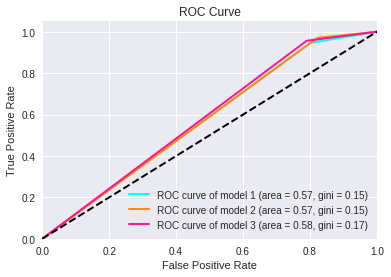

In [0]:
preds = [logReg.predict(X_test), randFor.predict(X_test), gbm.predict(X_test)]
plot_the_roc_dwayne_johnson(preds,['aqua', 'darkorange','deeppink'])
#['aqua', 'darkorange', 'cornflowerblue','deeppink','navy']

**Feature Importance**
- Let's take a look at the most important variables in our classifier models
- Tree Based: Variable Importance (gain)
- Logistic Regression: Coefficients, preserve sign of coefficient to determine effect on the model
- Selecting/engineering features is the most imperative aspect of creating an effective model!

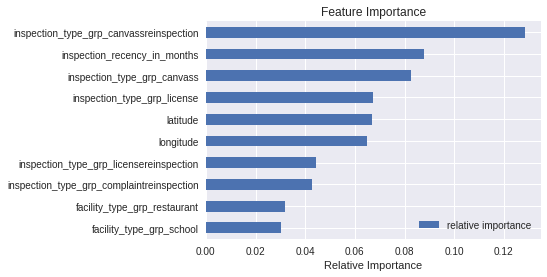

In [0]:
n = 10
plot_df = pd.DataFrame()

plot_df['relative importance'] = randFor.feature_importances_[randFor.feature_importances_.argsort()[::-1][:n]]
plot_df.index = X.columns[randFor.feature_importances_.argsort()[::-1][:n]]
plot_df.sort_values(by = 'relative importance', inplace = True)
#print(plot_df)

plot_df.plot.barh(title = 'Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

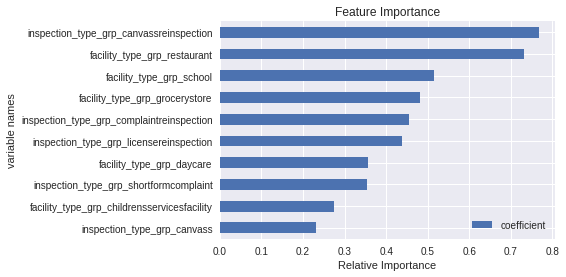

In [0]:
n = 10
plot_df = pd.DataFrame()

plot_df['variable names'] = X.columns
plot_df['coefficient'] =  logReg.coef_[0]
plot_df['abs_imp'] = [abs(c) for c in logReg.coef_[0]]
plot_df.sort_values(by = 'abs_imp', inplace = True)
plot_df = plot_df[['coefficient', 'variable names']].tail(n)
plot_df.index = plot_df['variable names']

plot_df.tail(10).plot.barh(title = 'Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

XGBoost outputs variable importance with three different importance types:
-	Gain: relative importance in generating a prediction; average training loss reduction gained when using feature for splitting
-	Cover: the number of times a feature is used to split the data across all trees, weighted by number of data points 
-	Weight: number of times a feature is used to split the data across all trees


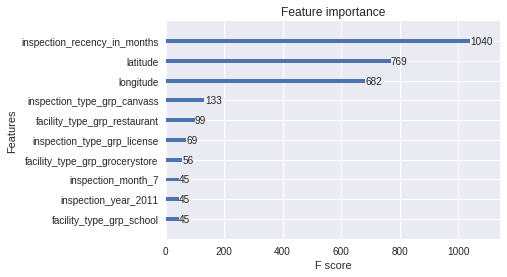

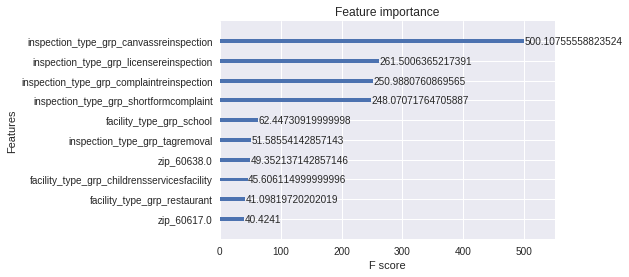

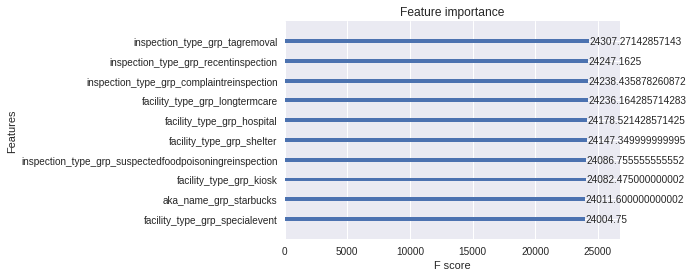

In [0]:
n = 10
plot_df = pd.DataFrame()
xgb.plot_importance(gbm, max_num_features = n, importance_type = 'weight')
xgb.plot_importance(gbm, max_num_features = n, importance_type = 'gain')
xgb.plot_importance(gbm, max_num_features = n, importance_type = 'cover')

**Part 3:** Hyperparameter Tuning

**Concept of Regularization**

Inherently, when fitting a model on the training dataset, it will have a better predictive accuracy on this data compared to outside data, which is why validation data exists. In order to correct overfitting and decrease bias of a model to training data, we can introduce regularization into the model. Think of this as adding a penalty or obstacle when the model tries to fit to the underlying training data. 

The figure below shows the divergence of training and test predictive error as the model complexity increases. As we introduce a small bit of complexity into the model, we can move toward a better fit on the testing set, which is what we ultimately care about most.

<img src="https://drive.google.com/uc?export=view&id=1z8isuqV9bGq3xy8jvKE1lPrizBd_7VNS">

**L1 and L2 Regularization**

- The easiest way to understand regularization is through regularized regression models. Lasso, Ridge, and Elastic Net. Recall that for regression models, coefficients are estimated using values that minimize the following objective function (residual sum squares):
<br>
<img = src="https://drive.google.com/uc?export=view&id=1GXR_Sfj1Gi1BM8lUb6eFC7J8VGdeQ1T1">
<br>
- Ridge and Lasso Regression introduce an $L_1$ and $L_2$ regularization term to the normal RSS function.

**Ridge Regression (**$L_2$**Regularization)**
- In Ridge Regression, the $L_2$ regularization term is added to the RSS formula.
- Now, we need to minimize this function subject to the sum of all coefficient estimates squared
- This will decrease the volatility of the parameter estimates, and force estimates close to zero when variable does not explain enough variance in the model, resulting in correlated variables sharing the signal in parameter estimates.
- The amount of the penalty applied is controlled by the tuning parameter which the user selects
    - If $\lambda$ is 0, it will result in OLS parameter estimates; if $\lambda$ is large, parameter estimates forced close to zero
    - Shown below as lambda, but ($\lambda$) in scikitlearn function it's alpha
    - Scikit learn's alpha is not to be confused with R's glmnet() alpha parameter which controls whether lasso, ridge or elastic net model is fit
<br><img = src="https://drive.google.com/uc?export=view&id=1rE7TavvJ5rivG9S48vJ2DNjAAyxsbKlB"><br>

**Lasso Regression (**$L_1$**Regularization)**
- In Lasso Regression, the $L_1$ regularization term is added to the RSS formula.
- Now, we need to minimize this function subject to the sum of the absolute values of all coefficient estimates
- This will decrease the volatility of the parameter estimates, and force estimates to zero when variable does not explain enough variance in the model or if variables are correlated. This is also a helpful tactic for feature selection.
- Again, amount of the penalty applied is controlled by the tuning parameter lambda ($\lambda$).
    - If $\lambda$ is 0, it will result in OLS parameter estimates; if $\lambda$ is large, parameter estimates forced to zero   
<br><img = src="https://drive.google.com/uc?export=view&id=1dW0VJHUBMKr1d182L7c1_DVnR-EJwlx_"><br>

**ElasticNet**
- Elastic-Net is a compromise between Lasso and Ridge. 
- Elastic-Net penalizes a mix of both absolute and squared size.
- The ratio of the two penalty types should be tuned. The overall strength should also be tuned.

There’s no "best" type of penalty. It really depends on the dataset and the problem. Try different algorithms that use a range of penalty strengths as part of the tuning process.

In [17]:
# lasso
# for logistic regression, we can use the C parameter (1/lambda) 
# in sklearn.linear_model.LogisticRegression()
# in my opinion, this is much easier to do in R with glmnet, and I recommend checking out 
# the python version of the package here: https://glmnet-python.readthedocs.io/en/latest/glmnet_vignette.html#Logistic-Regression
lassoLogReg = LogisticRegression(penalty='l1',
                                  n_jobs =-1,
                                  solver='liblinear',
                                  C=.05).fit(X_train, y_train)
print('number of non-zero logistic regression parameter estimates: ',
      len(logReg.coef_[0][logReg.coef_[0] != 0]))
print('number of non-zero lasso logistic regression parameter estimates: ',
    len(lassoLogReg.coef_[0][lassoLogReg.coef_[0] != 0]))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


number of non-zero logistic regression parameter estimates:  172
number of non-zero lasso logistic regression parameter estimates:  161


In [0]:
print(X_train.columns[lassoLogReg.coef_[0] == 0])

Index(['longitude', 'aka_name_grp_kentuckyfriedchicken',
       'aka_name_grp_panerabread', 'inspection_type_grp_canvass',
       'zip_60015.0', 'zip_60018.0', 'zip_60022.0', 'zip_60035.0',
       'zip_60044.0', 'zip_60047.0', 'zip_60076.0', 'zip_60077.0',
       'zip_60107.0', 'zip_60108.0', 'zip_60126.0', 'zip_60148.0',
       'zip_60153.0', 'zip_60155.0', 'zip_60176.0', 'zip_60193.0',
       'zip_60201.0', 'zip_60202.0', 'zip_60302.0', 'zip_60402.0',
       'zip_60406.0', 'zip_60409.0', 'zip_60411.0', 'zip_60423.0',
       'zip_60429.0', 'zip_60440.0', 'zip_60453.0', 'zip_60455.0',
       'zip_60458.0', 'zip_60461.0', 'zip_60464.0', 'zip_60477.0',
       'zip_60478.0', 'zip_60482.0', 'zip_60540.0', 'zip_60585.0',
       'zip_60609.0', 'zip_60657.0', 'zip_60706.0', 'zip_60714.0',
       'zip_60803.0', 'zip_60804.0', 'zip_60805.0', 'zip_60827.0',
       'inspection_year_2016', 'inspection_year_2017'],
      dtype='object')


**Hyperparameter Tuning (XGBoost Model)**
- Always be sure to read the documentation for the comprehensive list of hyperparameters available. For this example, we will look at the hyperparameters associated with a gradient boosting model in the XGBoost package. <br>
- Full hyperparameter list: https://xgboost.readthedocs.io/en/latest/parameter.html

Learning Task Hyperparameters
- *objective function:* examples for classification problems include logisitic regression for binary classification (returns predicted probability), multiclass classification using softmax objective (returns predicted class), or the same multiclass option returning probabilities instead of predicted classes
- *evaluation metric:* error metric to assess the model performance when fitting. Common values include rmse, logloss/mlogloss, error/merror, auc.
- *early stopping*: if the evaluation metric does not improve by n rounds of fitting, stop fitting model
- *nrounds*: number of rounds to fit model

Booster Hyperparameters
- *eta:* learning rate
- *min_child_weight:* minimum sum of weights of all observations required in a 'child', used to prevent overfitting
- *max_depth:* max number of levels in a tree
- *max_leaf_nodes:* max number of terminal nodes or leaves in a tree (can be used instead of max depth)
- *gamma:* mimimum loss reduction required to make a split
- *subsample:* fraction of observations used in each tree
- *colsample_bytree:* limits number of columns used in each tree; prevents overfitting
- *colsample_bylevel:* limits number of columns used in each level of tree; prevents overfitting (if you use subsample and colsample_bytree, you probably don't need this one)
- *lambda:* L2 regularization term on weight
- *alpha:* L1 regularization term on weight
- *scale_pos_weight:* use if there is a class imbalance

Notes:
- You should at least tune eta, nrounds, and max_depth
- The parameters are related to each other, if you have a low learning rate, you can also increase max_depth
- You can experiment with different evaluation metrics 

**Hyperparameter Tuning Workflow Example**

Heavily borrowed from: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ (this is a great website!!)

General parameter tuning steps for XGBoost outlined in article:
1. Choose a relatively high learning rate and determine the optimum number of trees based on this learning rate
2. Tune tree-specific hyperparameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the decided learning rate and number of trees
3. Tune the regularization hyperparameters (lambda and alpha) to help reduce model complexity and enhance performance
4. Lower learning rate and decide the optimal hyperparameters

Please note that this is **not** the only way to tune hyperparameters! You can use this as a starting point and experiment on your own to see what works best for you!


In [0]:
# code in the next few cells borrowed from Analytics Vidhya article
# not just copying because we are lazy - it is great starter/reference code to have handy.
# adapt it to your needs!
def modelfit(model, 
         x_inputs_train, 
         predictors, 
         y_input_train,
         x_inputs_test,
         y_input_test,
         evalmetric = 'logloss',
         useTrainCV = True, 
         cv_folds = 3, 
         early_stopping_rounds = 50):


if useTrainCV: #use cv to get n_estimators value for eta selected
    xgtrain = xgb.DMatrix(data = x_inputs_train, 
                        label = y_input_train.values)
    cvresult = xgb.cv(params = model.get_params(), 
                    dtrain = xgtrain, 
                    num_boost_round = model.get_params()['n_estimators'], 
                    nfold = cv_folds,
                    metrics = evalmetric, 
                    early_stopping_rounds = early_stopping_rounds)
    print('new n_estimator value: ', cvresult.shape[0])
    model.set_params(n_estimators = cvresult.shape[0]) # reset your nrounds to cv value

#Fit the algorithm on the data
model.fit(x_inputs_train, y_input_train, eval_metric = evalmetric)

#Predict training set:
dtrain_predictions = model.predict(x_inputs_train)
dtrain_predprob = model.predict_proba(x_inputs_train)[:,1]

#Predict test set:
dtest_predictions = model.predict(x_inputs_test)
dtest_predprob = model.predict_proba(x_inputs_test)[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy (Train): %.4g" % accuracy_score(y_input_train.values, 
                                               dtrain_predictions))
fpr, tpr, thresholds = roc_curve(y_input_train, dtrain_predprob)
print("AUC Score (Train): %f" % auc(fpr, tpr))
print("Accuracy (Test): %.4g" % accuracy_score(y_input_test.values, 
                                               dtest_predictions))
fpr, tpr, thresholds = roc_curve(y_input_test, dtest_predprob)
print("AUC Score (Test): %f" % auc(fpr, tpr))

feat_imp = xgb.plot_importance(model, importance_type = 'gain', max_num_features=15)

return model

Let's break this function down to see what it's doing. The cell below defines each of the different inputs to the function and sets parameters for our first model. Only use the lassoLet's break this function down tp see what it's doing. The cell below defines each of the different inputs to the function and sets parameters for our first model. Only use the non-zero weighted features from lasso model above.

In [20]:
x_inputs_train = X_train[X_train.columns[lassoLogReg.coef_[0] != 0]]
y_input_train = y_train
x_inputs_test = X_test[X_train.columns[lassoLogReg.coef_[0] != 0]]
y_input_test = y_test

predictors = X_train.columns[lassoLogReg.coef_[0] != 0]
print(x_inputs_train.shape, y_input_train.shape)
print(x_inputs_test.shape, y_input_test.shape)
print(predictors)

(124197, 161) (124197,)
(53228, 161) (53228,)
Index(['inspection_recency_in_months', 'latitude', 'aka_name_grp_7eleven',
       'aka_name_grp_aubonpain', 'aka_name_grp_bp', 'aka_name_grp_burgerking',
       'aka_name_grp_cermakproduce', 'aka_name_grp_chipotlemexicangrill',
       'aka_name_grp_citgo', 'aka_name_grp_cornerbakerycafe',
       ...
       'inspection_month_9', 'inspection_month_10', 'inspection_month_11',
       'inspection_month_12', 'inspection_year_2011', 'inspection_year_2012',
       'inspection_year_2013', 'inspection_year_2014', 'inspection_year_2015',
       'inspection_year_2018'],
      dtype='object', length=161)


In [0]:
xgb1 = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=6,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     seed=42,
     scale_pos_weight = 1)

model = xgb1
predictors = predictors
x_inputs_train = x_inputs_train
y_input_train = y_input_train
x_inputs_test = x_inputs_test
y_input_test = y_input_test
evalmetric = 'logloss'
useTrainCV = True
cv_folds = 3
early_stopping_rounds = 10

Create DMatrix for training data (sparse matrix used for XGBoost)

In [0]:
xgtrain = xgb.DMatrix(data = x_inputs_train.values, 
                      label = y_input_train.values)

In [0]:
%time
cvresult = xgb.cv(params = model.get_params(), 
                  dtrain = xgtrain, 
                  num_boost_round = model.get_params()['n_estimators'], 
                  nfold = cv_folds,
                  metrics = evalmetric, 
                  early_stopping_rounds = early_stopping_rounds, 
                  verbose_eval = True)
print(cvresult.shape[0])
import pickle
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/cvresult.pickle'
pickle.dump(cvresult, open(filename,'wb'))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
[0]	train-logloss:0.666609+0.000116877	test-logloss:0.666686+0.000125988
[1]	train-logloss:0.648287+0.000737456	test-logloss:0.64844+0.000816199
[2]	train-logloss:0.634661+0.000895577	test-logloss:0.634958+0.000655049
[3]	train-logloss:0.623935+0.0015841	test-logloss:0.62436+0.00137199
[4]	train-logloss:0.613966+0.0011839	test-logloss:0.614474+0.000835577
[5]	train-logloss:0.607046+0.00210516	test-logloss:0.60765+0.00164519
[6]	train-logloss:0.60063+0.00179758	test-logloss:0.601363+0.00117329
[7]	train-logloss:0.595696+0.0015424	test-logloss:0.596542+0.000820907
[8]	train-logloss:0.591502+0.00141823	test-logloss:0.592497+0.000608164
[9]	train-logloss:0.588243+0.00123273	test-logloss:0.589308+0.000427597
[10]	train-logloss:0.585767+0.00162295	test-logloss:0.586878+0.000745907
[11]	train-logloss:0.583536+0.00138837	test-logloss:0.584738+0.000439823
[12]	train-logloss:0.581661+0.00128933	test-logloss:0.582949+0.000274059
[13]

Train model using the parameters selected and use cross validation to select the appropriate number of rounds. Because this takes so long, save the result as a pickle file. A pickle file is similar to a zipfile - it's compresses objects and saves them locally into a file. This is super helpful for model objects, large lists/dicts, etc. For this example we print verbose output to see how XGBoost works. In practice, you can exclude this because it adds to runtime.

In [0]:
# load cvresult directly from pickle object to save time
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/cvresult.pickle'
with open(filename, 'rb') as cv:
    cvresult = pickle.load(cv)

model.set_params(n_estimators = cvresult.shape[0]) # reset your n_estimators to cv value 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=565,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [0]:
#Fit the algorithm on the data
model.fit(x_inputs_train, y_input_train, eval_metric = evalmetric)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=5, min_child_weight=6, missing=None, n_estimators=565,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [0]:
print(x_inputs_train.shape)
print(x_inputs_test.shape)

(124197, 161)
(53228, 161)


In [0]:
#Predict training set:
dtrain_predictions = model.predict(x_inputs_train)
dtrain_predprob = model.predict_proba(x_inputs_train)[:,1]

#Predict test set:
dtest_predictions = model.predict(x_inputs_test)
dtest_predprob = model.predict_proba(x_inputs_test)[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy (Train): %.4g" % accuracy_score(y_input_train.values, 
                                                 dtrain_predictions))
fpr, tpr, thresholds = roc_curve(y_input_train, dtrain_predprob)
print("AUC Score (Train): %f" % auc(fpr, tpr))
print("Accuracy (Test): %.4g" % accuracy_score(y_input_test.values, 
                                                 dtest_predictions))
fpr, tpr, thresholds = roc_curve(y_input_test, dtest_predprob)
print("AUC Score (Test): %f" % auc(fpr, tpr))


Model Report
Accuracy (Train): 0.7467
AUC Score (Train): 0.790472
Accuracy (Test): 0.7262
AUC Score (Test): 0.747168


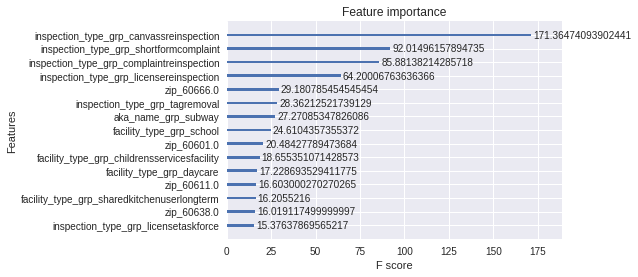

In [0]:
feat_imp = xgb.plot_importance(model, importance_type = 'gain', max_num_features=15)

In [0]:
# continue with this until you get a good fit for min child weight and max depth
param_test1 = {
 'max_depth':[2,5],
 'min_child_weight':[2,5]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.15,
                                                  n_estimators=cvresult.shape[0], # use cv result
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch1.fit(x_inputs_train, y_input_train)
gsearch1.best_estimator_, gsearch1.best_params_, gsearch1.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
        max_depth=5, min_child_weight=2, missing=None, n_estimators=565,
        n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
        subsample=0.8),
 {'max_depth': 5, 'min_child_weight': 2},
 0.744289047442682)

In [0]:
gsearch1.best_params_

{'max_depth': 5, 'min_child_weight': 2}

In [0]:
# tune gamma, using optimal max_depth and min_child_weight from above
param_test2 = {
 'gamma':[0, .25, .5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.15,
                                                  n_estimators=cvresult.shape[0], # use cv result
                                                  max_depth=gsearch1.best_params_['max_depth'], # use gridsearch1 cv result
                                                  min_child_weight=gsearch1.best_params_['min_child_weight'], # use gridsearch1 cv result
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid = param_test2,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch2.fit(x_inputs_train, y_input_train)
gsearch2.best_estimator_, gsearch2.best_params_, gsearch2.best_score_


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0.5, learning_rate=0.15,
        max_delta_step=0, max_depth=5, min_child_weight=2, missing=None,
        n_estimators=565, n_jobs=1, nthread=4, objective='binary:logistic',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=42, silent=True, subsample=0.8),
 {'gamma': 0.5},
 0.7447261850614194)

In [0]:
gsearch2.best_params_['gamma']

0.5

In [0]:
# tune subsample and colsample by tree
param_test3 = {
 'subsample':[.7,.8],
 'colsample_bytree':[.7,.8]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.15,
                                                  n_estimators=cvresult.shape[0], # use cv result
                                                  max_depth=gsearch1.best_params_['max_depth'], # use gridsearch1 cv result
                                                  min_child_weight=gsearch1.best_params_['min_child_weight'], # use gridsearch1 cv result
                                                  gamma=gsearch2.best_params_['gamma'],
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid = param_test3,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch3.fit(x_inputs_train, y_input_train)
gsearch3.best_estimator_, gsearch3.best_params_, gsearch3.best_score_


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0.5, learning_rate=0.15,
        max_delta_step=0, max_depth=5, min_child_weight=2, missing=None,
        n_estimators=565, n_jobs=1, nthread=4, objective='binary:logistic',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=42, silent=True, subsample=0.8),
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.7447261850614194)

In [0]:
gsearch3.best_params_

{'colsample_bytree': 0.8, 'subsample': 0.8}

In [0]:
# tune regularization parameter
param_test4 = {
 'reg_alpha':[0, 0.005, 0.05]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.15,
                                                  n_estimators=cvresult.shape[0], # use cv result
                                                  max_depth=gsearch1.best_params_['max_depth'], # use gridsearch1 cv result
                                                  min_child_weight=gsearch1.best_params_['min_child_weight'], # use gridsearch1 cv result
                                                  gamma=gsearch2.best_params_['gamma'],
                                                  subsample=gsearch3.best_params_['subsample'],
                                                  colsample_bytree=gsearch3.best_params_['colsample_bytree'],
                                                  objective= 'binary:logistic',
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid = param_test4,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)
gsearch4.fit(x_inputs_train, y_input_train)
gsearch4.best_estimator_, gsearch4.best_params_, gsearch4.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0.5, learning_rate=0.15,
        max_delta_step=0, max_depth=5, min_child_weight=2, missing=None,
        n_estimators=565, n_jobs=1, nthread=4, objective='binary:logistic',
        random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
        seed=42, silent=True, subsample=0.8),
 {'reg_alpha': 0.05},
 0.744875773084273)

In [0]:
gsearch4.best_params_

{'reg_alpha': 0.05}

In [0]:
# fit model again you can tweak learning rate if you want
xgb2 = xgb.XGBClassifier( learning_rate =0.15,
                      n_estimators=cvresult.shape[0], # use cv result
                      max_depth=gsearch1.best_params_['max_depth'], # use gridsearch1 cv result
                      min_child_weight=gsearch1.best_params_['min_child_weight'], # use gridsearch1 cv result
                      gamma=gsearch2.best_params_['gamma'],
                      subsample=gsearch3.best_params_['subsample'],
                      colsample_bytree=gsearch3.best_params_['colsample_bytree'],
                      objective= 'binary:logistic',
                      reg_alpha = gsearch4.best_params_['reg_alpha'],
                      nthread=4, 
                      scale_pos_weight=1,
                      seed=42)

In [0]:
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/xgb2.pickle'
pickle.dump(xgb2, open(filename,'wb'))

new n_estimator value:  565

Model Report
Accuracy (Train): 0.7505
AUC Score (Train): 0.798112
Accuracy (Test): 0.7275
AUC Score (Test): 0.748026


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.15,
       max_delta_step=0, max_depth=5, min_child_weight=2, missing=nan,
       n_estimators=565, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

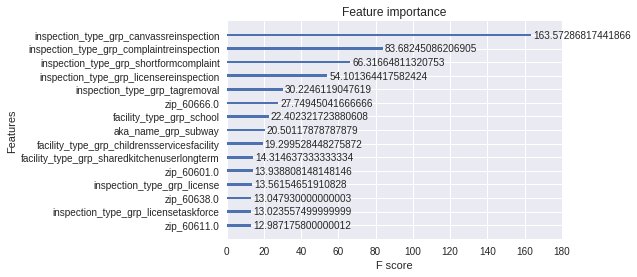

In [0]:
# load cvresult directly from pickle object to save time
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/xgb2.pickle'
with open(filename, 'rb') as x:
    xgb2 = pickle.load(x)

    
final_model = modelfit(model = xgb2, 
                       x_inputs_train = x_inputs_train, 
                       predictors = predictors,
                       y_input_train = y_input_train,
                       x_inputs_test = x_inputs_test,
                       y_input_test = y_input_test,) #function

final_model

In [0]:
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/final_model.pickle'
pickle.dump(final_model, open(filename,'wb'))

**Model Interpretation**
- Now that we have the models, it's time to interpret what they mean! This means answering questions like: which variables are most important to the model? Which variables are least important to the model? Does anything surprise you about the results?
- What are the effects of each of the variables in the model? What is the interpretation?
- Always look at the important variables for each model fit. If an unexpected variable is extremely important, be sure to try and understand why and check null values. If nulls are biased in one direction of a certain feature, it can increase importance of unexpected variables.

**Using the SHAP package to help explain your model**<br>
- In many cases, such as explaining a model to client or audience. A good way to do this is through the SHAP package. SHAP assigns each feature and importance value for a particular prediction.
- SHAP values represent a feature's responsibility for a change in the model output and values are much more consistent compared to the weight, gain, and cover metrics
- Helpful article: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

**Running SHAP in Jupyter Notebook:**

In [0]:
## load the final xgboost model (was getting a few errors trying to use shap in google colab with xgboost model)
filename = 'pickle/final_model.pickle'
with open(filename, 'rb') as m:
    final_model = pickle.load(m)

In [0]:
shap_values = shap.TreeExplainer(final_model).shap_values(x_inputs_test)

**Summary Plot**
-	The x position of the dot is the impact of that feature on the model’s prediction overall, and the color of the dot represents the value of that feature for the establishment-level prediction (each row). 
-	The features are sorted by the mean absolute value of SHAP (importance) from top to bottom, and since the XGBoost model has a logistic loss, the x-axis has units of log-odds 


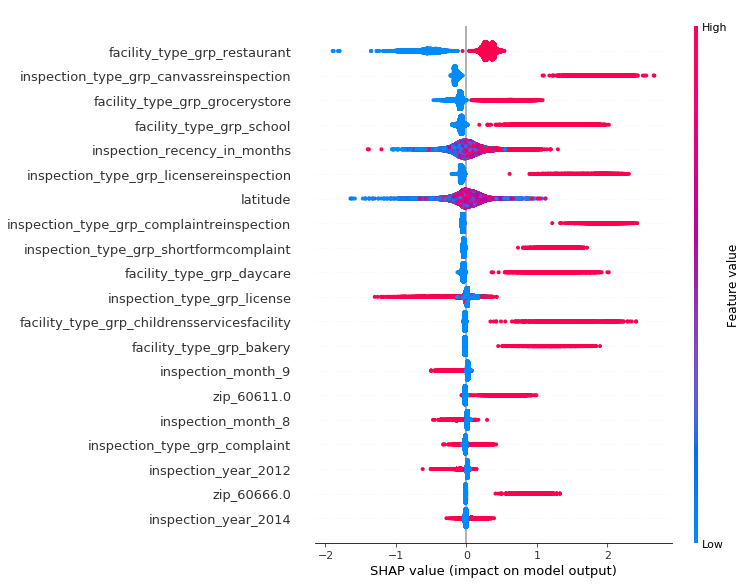

In [0]:
filename = 'pickle/shap_values_xgb.pickle'
with open(filename, 'rb') as m:
    shap_values = pickle.load(m)
shap.summary_plot(shap_values, x_inputs_test)

Dependence Plot

- The x position of the dot is the actual value of the feature chosen to display. The y position shows the shap value for the variable chosen. The color shows the shap value of an interaction term, which is selected automatically.
- Used to look at interactions.

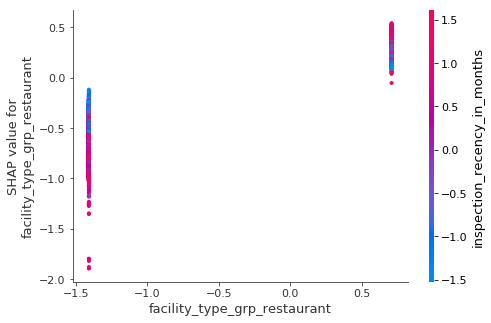

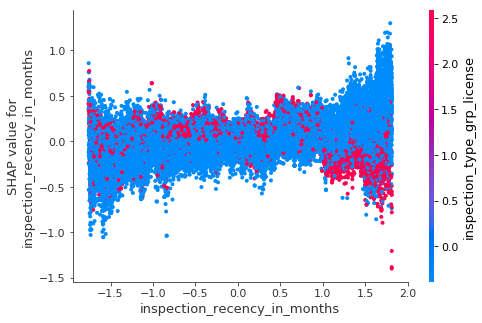

In [0]:
shap.dependence_plot('facility_type_grp_restaurant', 
                     shap_values, x_inputs_test)
shap.dependence_plot('inspection_recency_in_months', 
                     shap_values, x_inputs_test)

Row-Level Plot

- This plot shows the effect of each of the variables in the model on the overall SHAP output value
- Useful if you need something at a customer or row level

In [0]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(final_model).expected_value[0], 
                shap_values[0,:], x_inputs_test.iloc[0,:])

In [0]:
filename = 'pickle/shap_values_xgb.pickle'
pickle.dump(shap_values, open(filename,'wb'))

**Running SHAP in Google Colab:** <br>
- For whatever reason, there are slight differences in running shap in google colab. I also had issues getting shap_values for xgboost models. Hopefully this isn't an issue on your machine, but if it is, I would use SHAP in jupyter notebook instead.

In [0]:
## load the final xgboost model (was getting a few errors trying to use shap in google colab with xgboost model)
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/final_model.pickle'
with open(filename, 'rb') as m:
    final_model = pickle.load(m)

In [0]:
## I am getting errors when trying to do this - it may have something to do with the version of xgboost on google colab
#shap_values = shap.TreeExplainer(final_model).shap_values(x_inputs_test)

In [0]:
## load the shap values from running in python
filename = '/content/drive/My Drive/wids-brownbag-model-selection-and-eval-101/pickle/shap_values_xgb.pickle'
with open(filename, 'rb') as m:
    shap_values = pickle.load(m)

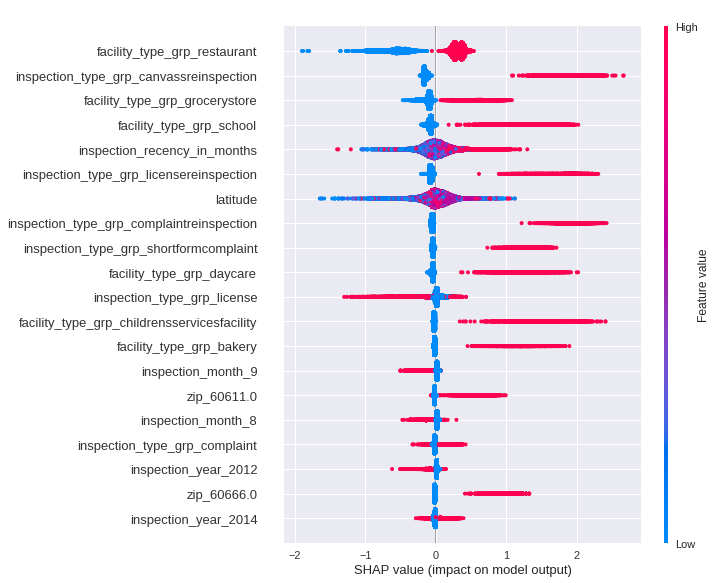

In [28]:
# create summary plot
shap.summary_plot(shap_values, x_inputs_test)

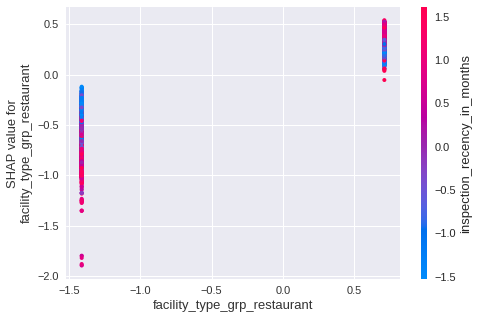

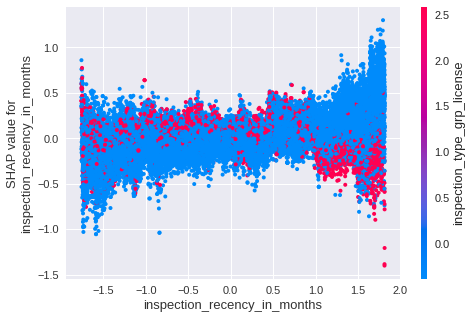

In [31]:
shap.dependence_plot('facility_type_grp_restaurant', 
                     shap_values, x_inputs_test)
shap.dependence_plot('inspection_recency_in_months', 
                     shap_values, x_inputs_test)
# automatically grabs the variable with highest interaction 

In [33]:
# show impact of variables on output value for a single observation
shap.initjs()
shap.force_plot(shap.TreeExplainer(final_model).expected_value[0], 
                shap_values[0,:], x_inputs_test.iloc[0,:])

**Questions?**
- Do you have questions, different ways to approach model selection, model evaluation, or parameter tuning?